### Ice-Water Classification: label propagation for the classification of 'ice' and 'water' from a Sentinel-1 EW GRDM image subset

---
Ice-water classification is performed on a subset of the example S1 image used throughout this notebook. The classification method implemented here is called Label Propagation, and is implemented using scikit-learn (https://scikit-learn.org/stable/modules/generated/sklearn.semi_supervised.LabelPropagation.html). Due to the high computational cost of Label Propagation, we cannot classify the whole Sentinel-1 scene at once, but only a small subset (1000 x 1000 pixels). Label Propagation is a semi-supervised, graph-based classification method. As it is semi-supervised, at least one labeled polygon per class is required as input. We manually label a few polygons in the SAR image, and save those as a label mask. The pre-processed image subsets and corresponding label mask are found in the _data_ folder.

The _data_ folder contains 4 files: _Sigma0_HH_db_, _Sigma0_HV_db_, _label_mask_, and _labels.txt_. _Sigma0_HH_db_ and _Sigma0_HV_db_ are the calibrated and multilooked image subsets, for both image channels. The file 'label_mask' is an image mask of the same size as the image subsets, which contains the manually labeled polygons for the different classes we want to classify in the image. At least one labeled polygon per class is required in the label mask.

The image subsets ('Sigma0_HH_db' and 'Sigma0_HV_db') need to be normalized before entering them in the label propagation algorithm. Different normalization options are implemented here, and their respective results on the image crops are visualized. 

---

### Import of packages needed in this code

In [1]:
# import packages
from sklearn.semi_supervised import LabelPropagation
import sklearn.preprocessing as p
import numpy as np
from osgeo import gdal
import matplotlib.pyplot as plt
import matplotlib as mpl

### Load input images and label mask from 'data' directory 

In [1]:
# define data directory
data_dir = './data/S1A_EW_GRDM_1SDH_20200330T043712_20200330T043819_031900_03AEB2_CC99/'

#read in bands with gdal
sigma0_hh = gdal.Open(data_dir + 'Sigma0_HH_db.img').ReadAsArray()
sigma0_hv = gdal.Open(data_dir + 'Sigma0_HV_db.img').ReadAsArray()
label_mask = gdal.Open(data_dir + 'label_mask.img').ReadAsArray()

# open text file containing the labels of the sea ice type classes
labels_txt = data_dir + 'labels.txt'

NameError: name 'gdal' is not defined

### Define the class label dictionary
The class label dictionary contains digits as keys, and the corresponding ice type labels as values (e.g. 1 : 'level ice'). This mapping is needed to visualise the label mask and the final classification result.

In [3]:
# read class labels from labels_txt into a list
with open(labels_txt) as f:
    class_labels = f.read().splitlines()
print('The class labels are:', class_labels)

# make dictionary with label-value mapping
# 0 is background in label mask
class_label_dict = { 0 : 'background'}

value_label_mapping = {}
for idx, label in enumerate(class_labels):
      value_label_mapping[idx + 1] = label

assert 0 not in value_label_mapping.values(), \
'Zero label is reserved for background!'

# combine background and value_label_mapping
class_label_dict.update(value_label_mapping)

print('The class label dictionary is defined as:', class_label_dict)

The class labels are: ['ice', 'water']
The class label dictionary is defined as: {0: 'background', 1: 'ice', 2: 'water'}


### Visualize the input images and label mask

In [4]:
# Prepare the colormap

# define a set of class colors
class_colors =  [
      [  0,  0,  0], 
      [  0,50,255], 
      [150,220,255], 
      [85, 125,160], 
      [170,40, 240], 
      [ 240, 80, 0], 
      [215,250,130], 
      [0,  120,  0], 
      [200, 60,  5]
      ]

# select as many colours as there are classes (here: 'ice' and 'water') + 1 color for background (black)
class_colors = class_colors[0:len(class_label_dict)]

# normalize class colors
class_colors_norm = []
for c in class_colors:
  c_norm = [ v/255 for v in c ]
  class_colors_norm.append(c_norm)

# define level boundaries for colormap
cmap_bounds = np.arange(-0.5,len(class_colors) + 0.5, 1)
cmap_values = np.convolve(cmap_bounds, np.ones(2)/2, mode='valid').astype(int)

# build colormap
cmap = mpl.colors.ListedColormap(
  class_colors_norm,
  name='my_cmap'
)

# build a colormap index based on level boundaries
cmap_norm = mpl.colors.BoundaryNorm(cmap_bounds, cmap.N)

# build legend/labels for colorbar
legend_entries = list(class_label_dict.values())

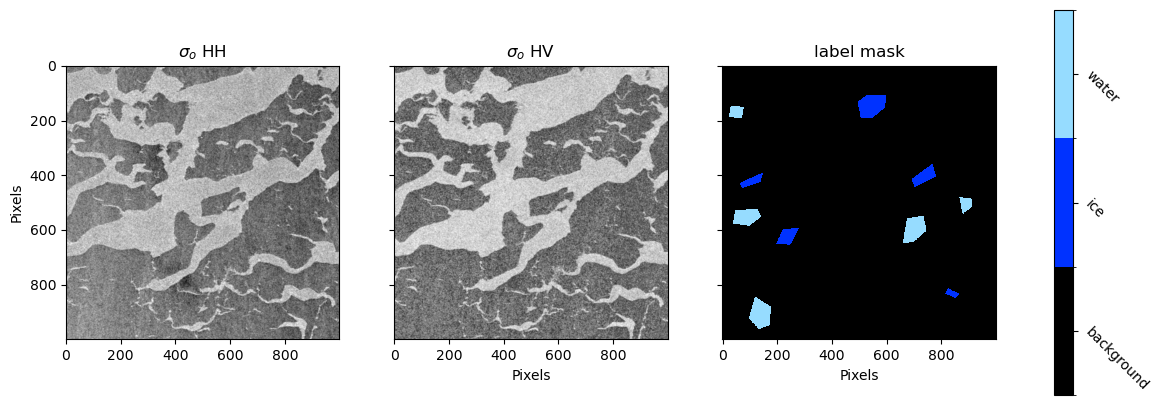

In [5]:
# make plot
fig, axes = plt.subplots(1,3, sharex=True, sharey=True, figsize=(15,5))
axes = axes.ravel()

axes[0].imshow(sigma0_hh, cmap = 'gray')
axes[0].set_title('$\sigma_o$ HH')
axes[0].set_ylabel('Pixels')

axes[1].imshow(sigma0_hv, cmap = 'gray')
axes[1].set_title('$\sigma_o$ HV')
axes[1].set_xlabel('Pixels')

# plot label mask
s = axes[2].imshow(
  label_mask,
  cmap = cmap,
  norm = cmap_norm,
  interpolation='nearest'
)
axes[2].set_title('label mask')
axes[2].set_xlabel('Pixels')

cbar = fig.colorbar(
  s,
  ax = axes,
  ticks = cmap_values
)
cbar.set_ticklabels(legend_entries)
cbar.ax.tick_params(rotation=-45)

### Prepare input bands and label mask for label propagation
Preparing the data for label propagation happens in 3 steps, described one by one here.

**_Step 1: update label mask_**  <br> The label propagation algorithm in scikit-learn requires all unlabeled samples to have value -1. In our original label mask, the unlabeled samples had value 0, so we replace all 0 values by -1.

In [6]:
# replace 0 entries by -1 (meaning unlabelled)
label_mask = label_mask.astype('int8')
label_mask[np.where(label_mask==0)] = -1

**_Step 2: normalize data_**  <br> The input bands (HH and HV bands in this case) need to be normalized. Normalizing data can be done in different ways, this script implements and visualizes 4 different options.

In [7]:
# define custom function to normalize using percentiles
def normalize_percentiles(X, new_min, new_max):
    # normalize array X in range (new_min, new_max)
    
    # find nan percentiles of array X
    Xmin = np.nanpercentile(X , 0.1)
    Xmax = np.nanpercentile(X , 99.9)
    
    # clip min-max values of X
    X[X<Xmin] = Xmin
    X[X>Xmax] = Xmax
    
    # scale X to new range
    X_scaled = (X - Xmin) / (Xmax - Xmin) * (new_max - new_min) + new_min 
    
    return X_scaled

# normalize input bands using L2 norm
sigma0_hh_normalized = p.normalize(sigma0_hh, norm='l2')
sigma0_hv_normalized = p.normalize(sigma0_hv, norm='l2')

# normalize input bands using percentiles instead of min and max values
sigma0_hh_normalized = normalize_percentiles(sigma0_hh, 0, 1)
sigma0_hv_normalized = normalize_percentiles(sigma0_hv, 0, 1)

# normalize bands using the min and max values
scaler = p.MinMaxScaler()
sigma0_hh_scaled = scaler.fit_transform(sigma0_hh)

# normalize bands using median and interquartile range
robustscaler = p.RobustScaler()
sigma0_hh_scaled_robust = robustscaler.fit_transform(sigma0_hh)

Text(0.5, 0, 'Pixels')

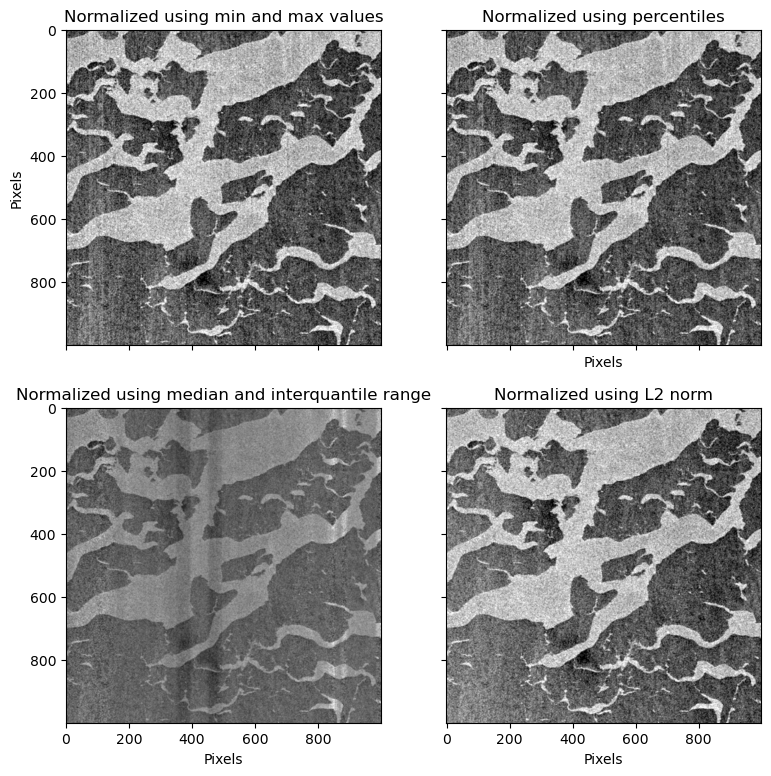

In [8]:
# make plot

# visualize effect of different normalization options

fig, axes = plt.subplots(2,2, sharex=True, sharey=True, figsize=(9,9))
axes = axes.ravel()

axes[0].imshow(sigma0_hh_scaled, cmap='gray')
axes[0].set_title('Normalized using min and max values')
axes[0].set_ylabel('Pixels')

axes[1].imshow(sigma0_hh_scaled, cmap='gray')
axes[1].set_title('Normalized using percentiles')
axes[1].set_xlabel('Pixels')

axes[2].imshow(sigma0_hh_scaled_robust, cmap='gray')
axes[2].set_title('Normalized using median and interquantile range')
axes[2].set_xlabel('Pixels')

axes[3].imshow(sigma0_hh_normalized, cmap='gray')
axes[3].set_title('Normalized using L2 norm')
axes[3].set_xlabel('Pixels')

#### We decide to normalize the input images using the L2 norm.

**_Step 3: stack and flatten input bands and label mask_**  <br> The different input bands (HH and HV) are stacked pixelwise into a 3D array 'X'. The label propagation algorithm from scikit-learn expects as input a data array of shape (N,1) and a label mask of shape (N,1), where N is the total amount of samples in an input band. We therefore flatten the 3D array 'X' into a 1D array. We also flatten the label mask ('y').

In [9]:
# stack bands to create input X
X = np.stack([sigma0_hh_normalized, sigma0_hv_normalized], axis=-1)

# flatten input X and y to 1D
X = np.reshape(X, (X.shape[0] * X.shape[1], X.shape[2]))
y = np.ravel(label_mask)

### Implementation of Label Propagation for the classification of sea ice types
**Note**: this step takes long to run!

In [10]:
# create LP model
lp_model = LabelPropagation(kernel='knn', n_neighbors=30, n_jobs=-1)

# fit data to model
lp_model.fit(X,y)

LabelPropagation(kernel='knn', n_jobs=-1, n_neighbors=30)

In [11]:
# predict label for each pixel
predicted_image = lp_model.predict(X)
# reshape to 2D image
predicted_image = np.reshape(predicted_image, (label_mask.shape))

/opt/conda/lib/python3.10/site-packages/sklearn/semi_supervised/_label_propagation.py:222: RuntimeWarning: invalid value encountered in divide
  probabilities /= normalizer


### Plot results of Label Propagation

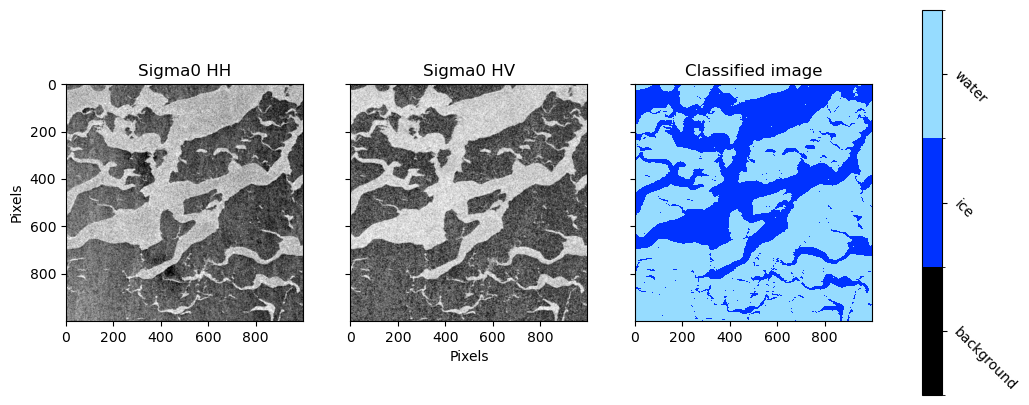

In [12]:
# make plot
fig, axes = plt.subplots(1,3, sharex=True, sharey=True, figsize=(13,5))
axes = axes.ravel()

axes[0].imshow(
    sigma0_hh,
    cmap = 'gray'
    )
axes[0].set_title('Sigma0 HH')
axes[0].set_ylabel('Pixels')

axes[1].imshow(
    sigma0_hv,
    cmap = 'gray'
    )
axes[1].set_title('Sigma0 HV')
axes[1].set_xlabel('Pixels')

s = axes[2].imshow(
  predicted_image,
  cmap = cmap,
  norm = cmap_norm,
  interpolation='nearest'
)
axes[2].set_title('Classified image')

cbar = fig.colorbar(
  s,
  ax = axes,
  ticks = cmap_values
)
cbar.set_ticklabels(legend_entries)
cbar.ax.tick_params(rotation=-45)

No ground thruth is available for this SAR image, so we judge the classification result by visually comparing the input images with the classification map. In this case, the classification result is satisfying, as all areas we expected to be ice, are classified correctly as 'ice'. 